## Grab the train and test

In [1]:
import os
import numpy as np
# import zipfile

In [2]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import timm
from torch.utils.data import dataloader,DataLoader
import matplotlib.pyplot as plt

c:\Users\aswin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Create Custom DataSet class

In [6]:
train_dir = "../split_dataset/train"
test_dir = "../split_dataset/test"


#### Data Transformation

In [1]:
## ENABLE WHEN USING CHICKEN DETECTOR CLASS

# # Transform for training dataset
# train_transform = transforms.Compose([
#     transforms.Resize((128, 128)),               # Resize to 128x128
#     transforms.ToTensor(),                       # Convert image to PyTorch tensor
# ])

# # Transform for test dataset
# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

In [2]:
# ENABLE WHEN USING EFFICIENT NET CLASS

# Transform for training dataset
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),               # Resize to 300x300
    transforms.ToTensor(),                       # Convert image to PyTorch tensor
])

# Transform for test dataset
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

NameError: name 'transforms' is not defined

In [ ]:
## Loading the dataset

train_dataset = ImageFolder(root=train_dir,transform=train_transform)
test_dataset = ImageFolder(root=test_dir,transform=test_transform)

In [ ]:
train_dataset.classes

['cocci', 'healthy', 'ncd', 'salmo']

In [ ]:
# Create DataLoaders for train and test datasets

# Optimize your DataLoaders with more workers and prefetching
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True,
    num_workers=4,  # Increase worker processes
    pin_memory=True,  # Helps with faster data transfer to GPU
    prefetch_factor=2  # Prefetch batches
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

 Build the CNN Model

In [ ]:
class ChickenDiseaseDetector(nn.Module):
  """
  Model Arch replicates TinyVGG model
  from CNN explainer website

  """

  def __init__(self, input_shape:int, hidden_units:int, output_shape:int,image_dimension:int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2=nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*image_dimension//2//2*image_dimension//2//2,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))



In [ ]:
torch.manual_seed(42)
model=ChickenDiseaseDetector(input_shape=3,
                            hidden_units=10,
                            output_shape=4,
                            image_dimension=128).to(device)

model

ChickenDiseaseDetector(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=4, bias=True)
  )
)

In [ ]:
class MobileeNetV2(nn.Module):
    def __init__(self, num_classes: int):
        super(MobileeNetV2, self).__init__()
        
        # Load EfficientNetB3 base model
        self.base_model = timm.create_model(
            'mobilenetv2_100', 
            pretrained=True,
            num_classes=0  # Remove original classification head
        )
        
        # Freeze base model if fine-tuning is not needed
        # for param in self.base_model.parameters():
        #     param.requires_grad = False
        
        # Add custom classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.base_model.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


In [ ]:
torch.manual_seed(42)
model=MobileeNetV2(num_classes=4).to(device)
model

MobileeNetV2(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU6(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU6(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity(

In [ ]:
class EarlyStopping():
    def __init__(self,patience=5,min_delta=1e-2,restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None
        self.best_epoch = None
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()
            self.best_epoch = epoch
            print(f"Current Best model found at epoch {epoch} with loss {val_loss:.4f}.")
        else:
            self.counter +=1
            print(f"Validation Loss: {val_loss:.4f} did not improve compared to best loss: {self.best_loss:.4f}. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop=True
                print(f"Early stopping triggered after {self.counter} checks without improvement.")
                if self.restore_best_weights and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights)



In [ ]:
## Load a sample image from train dataloader
sample_batch,sample_label=next(iter(train_loader))
sample_batch.shape

torch.Size([16, 3, 300, 300])

In [ ]:
# image = torch.randn(32,3,128,128)

# conv_block_1=nn.Sequential(
#         nn.Conv2d(in_channels=3,
#                   out_channels=10,
#                   kernel_size=3,
#                   stride=1,
#                   padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=10,
#                   out_channels=10,
#                   kernel_size=3,
#                   stride=1,
#                   padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2)
#     )

# conv_block_2=nn.Sequential(
#     nn.Conv2d(in_channels=10,
#                   out_channels=10,
#                   kernel_size=3,
#                   stride=1,
#                   padding=1),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=10,
#                   out_channels=10,
#                   kernel_size=3,
#                   stride=1,
#                   padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2)
#     )
# classifier=nn.Sequential(
#         nn.Flatten(),
#         nn.Linear(in_features=10*32*32,
#                   out_features=4)
#     )

# print(image.shape)
# print(conv_block_1(image).shape)
# print(conv_block_2(conv_block_1(image)).shape)
# print(classifier(conv_block_2(conv_block_1(image))).shape)

In [ ]:
# Simulate a batch of dummy images (EfficientNetB3 expects 300x300)
dummy_input = torch.randn(16, 3, 300, 300).to(device)  # Batch of 32


# Forward pass to debug
with torch.no_grad():
    output = model(dummy_input)
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)  # Should be [32, 4]

Input shape: torch.Size([16, 3, 300, 300])
Output shape: torch.Size([16, 4])


## Get Helper Functions

In [43]:
import requests
import os

if os.path.exists("helper_functions.py"):
  print("Skipping download, helper_functions.py exists!")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Skipping download, helper_functions.py exists!


In [44]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, print_train_time

## Train-Test Loop time Functions

In [45]:
train_loss_arr=[]
test_loss_arr=[]

train_acc_arr=[]
test_acc_arr=[]

In [46]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               accuracy_fn:accuracy_fn):

  """Performs a training with model trying to learn on data_loader"""

  train_loss,train_acc=0,0
  model.train()



    ## Training
  train_loss=0 ## for calculating training_loss per batch

    ## Add a loop to loop through the training batches
  for batch,(X,y) in enumerate(dataloader):

    X,y=X.to(device),y.to(device)

      ## Forward pass
    y_pred=model(X)

      ## Calc the loss(per batch)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))

      ## Optimizer zero grad
    optimizer.zero_grad()

      ## Loss backward
    loss.backward()

      ## Optimizer step
    optimizer.step()



  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)

  print(f"\n Train Loss: {train_loss:.4f}  | Train Accuracy: {train_acc}")





In [47]:
def test_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device,
               accuracy_fn:accuracy_fn):

  """Performs a testing with model trying to learn on data_loader"""

  test_loss,test_acc=0,0
  model.eval()

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):

      X,y=X.to(device),y.to(device)

      ## Forward pass
      y_pred=model(X)

      ## Calc the loss(per batch)
      loss=loss_fn(y_pred,y)
      test_loss+=loss.item()
      test_acc+=accuracy_fn(y,y_pred.argmax(dim=1))

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
    test_loss_arr.append(test_loss)
    test_acc_arr.append(test_acc)

  print(f"\n Test Loss: {test_loss:.4f}  | Test Accuracy: {test_acc}")



In [48]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn=torch.nn.Module,
               accuracy_fn=accuracy_fn):
  """
  Returns a dictionary containing the results of model predicting on data_loader.
  """

  loss,acc=0,0

  model.eval()
  with torch.inference_mode():

    for X,y in data_loader:

      X,y=X.to(device),y.to(device)

      ## Forward pass
      y_pred=model(X)
      ## Calc the loss(per batch)
      loss+=loss_fn(y_pred,y)
      ## Calc the accuracy(per batch)
      acc+=accuracy_fn(y,y_pred.argmax(dim=1))

    ## Adjust metrics to get average loss and accuracy per batch
    loss=loss/len(data_loader)
    acc/=len(data_loader)


  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

## Setting up Loss function and optimizer

In [51]:
## Train the CNN on our dataset

## Setup loss func, eval metrics, optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),
                          lr=0.001)


In [52]:
# Pre-warm both data loaders
print("Pre-warming train data loader...")
_ = next(iter(train_loader))  # Get first batch to warm up the loader

print("Pre-warming test data loader...")
_ = next(iter(test_loader))  # Get first batch from test loader

print("Both DataLoaders initialized, starting training...")

Pre-warming train data loader...
Pre-warming test data loader...
Both DataLoaders initialized, starting training...


In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from tqdm.auto import tqdm ## For progress bar

validate_every_n_epochs = 2  # Run validation every 2 epochs

early_stopper = EarlyStopping(patience=5, min_delta=1e-3)

epochs=100


train_time_on_device_start=timer()

for epoch in tqdm(range(1,epochs+1), desc="Training Epochs", unit="epoch"):
  print(f"Epoch: {epoch}\n---------")


  train_step(model=model,
             dataloader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device,
             accuracy_fn=accuracy_fn)

  # Check if this is a validation epoch
  if epoch % validate_every_n_epochs == 0:
    test_step(model=model,
              dataloader=test_loader,
              loss_fn=loss_fn,
              device=device,
              accuracy_fn=accuracy_fn)
    
    # Use the latest validation (test) loss for early stopping
    current_val_loss = test_loss_arr[-1]
    early_stopper(model, current_val_loss, epoch)

    if early_stopper.early_stop:
      print("🛑 Early stopping!")
      break

  else:
    # Append NaNs or placeholders so arrays match in size
      test_loss_arr.append(float('nan'))
      test_acc_arr.append(float('nan'))


     

train_time_on_device_end=timer()



Training Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch: 1
---------


Training Epochs:   1%|          | 1/100 [02:48<4:38:44, 168.94s/epoch]


 Train Loss: 0.3561  | Train Accuracy: 87.80598958333333
Epoch: 2
---------

 Train Loss: 0.2236  | Train Accuracy: 92.52604166666667


Training Epochs:   2%|▏         | 2/100 [07:01<5:56:24, 218.20s/epoch]


 Test Loss: 0.1094  | Test Accuracy: 96.31742738589212
Current Best model found at epoch 2 with loss 0.1094.
Epoch: 3
---------


Training Epochs:   3%|▎         | 3/100 [09:30<5:01:23, 186.43s/epoch]


 Train Loss: 0.1641  | Train Accuracy: 94.62890625
Epoch: 4
---------

 Train Loss: 0.1413  | Train Accuracy: 95.31901041666667


Training Epochs:   4%|▍         | 4/100 [12:57<5:11:09, 194.48s/epoch]


 Test Loss: 0.0843  | Test Accuracy: 97.17323651452283
Current Best model found at epoch 4 with loss 0.0843.
Epoch: 5
---------


Training Epochs:   5%|▌         | 5/100 [15:25<4:41:24, 177.73s/epoch]


 Train Loss: 0.1164  | Train Accuracy: 96.23046875
Epoch: 6
---------

 Train Loss: 0.1030  | Train Accuracy: 96.64713541666667


Training Epochs:   6%|▌         | 6/100 [18:46<4:51:15, 185.90s/epoch]


 Test Loss: 0.0644  | Test Accuracy: 97.9253112033195
Current Best model found at epoch 6 with loss 0.0644.
Epoch: 7
---------


Training Epochs:   7%|▋         | 7/100 [21:13<4:28:21, 173.14s/epoch]


 Train Loss: 0.0880  | Train Accuracy: 97.19100560897436
Epoch: 8
---------

 Train Loss: 0.0853  | Train Accuracy: 97.18599759615384


Training Epochs:   8%|▊         | 8/100 [24:33<4:38:17, 181.49s/epoch]


 Test Loss: 0.0839  | Test Accuracy: 97.32883817427386
Validation Loss: 0.0839 did not improve compared to best loss: 0.0644. Counter: 1/5
Epoch: 9
---------


Training Epochs:   9%|▉         | 9/100 [27:00<4:18:56, 170.74s/epoch]


 Train Loss: 0.0683  | Train Accuracy: 97.75390625
Epoch: 10
---------

 Train Loss: 0.0757  | Train Accuracy: 97.38932291666667


Training Epochs:  10%|█         | 10/100 [30:19<4:29:08, 179.43s/epoch]


 Test Loss: 0.0534  | Test Accuracy: 98.26244813278008
Current Best model found at epoch 10 with loss 0.0534.
Epoch: 11
---------


Training Epochs:  11%|█         | 11/100 [32:48<4:12:22, 170.14s/epoch]


 Train Loss: 0.0670  | Train Accuracy: 97.734375
Epoch: 12
---------

 Train Loss: 0.0603  | Train Accuracy: 98.02083333333333


Training Epochs:  12%|█▏        | 12/100 [36:12<4:24:35, 180.41s/epoch]


 Test Loss: 0.0762  | Test Accuracy: 97.71784232365145
Validation Loss: 0.0762 did not improve compared to best loss: 0.0534. Counter: 1/5
Epoch: 13
---------


Training Epochs:  13%|█▎        | 13/100 [38:40<4:07:29, 170.69s/epoch]


 Train Loss: 0.0501  | Train Accuracy: 98.25520833333333
Epoch: 14
---------

 Train Loss: 0.0514  | Train Accuracy: 98.29427083333333


Training Epochs:  14%|█▍        | 14/100 [41:57<4:16:15, 178.79s/epoch]


 Test Loss: 0.0772  | Test Accuracy: 97.74377593360995
Validation Loss: 0.0772 did not improve compared to best loss: 0.0534. Counter: 2/5
Epoch: 15
---------


Training Epochs:  15%|█▌        | 15/100 [44:23<3:59:19, 168.93s/epoch]


 Train Loss: 0.0537  | Train Accuracy: 98.26822916666667
Epoch: 16
---------

 Train Loss: 0.0467  | Train Accuracy: 98.39192708333333


Training Epochs:  16%|█▌        | 16/100 [47:43<4:09:26, 178.17s/epoch]


 Test Loss: 0.0822  | Test Accuracy: 97.84751037344398
Validation Loss: 0.0822 did not improve compared to best loss: 0.0534. Counter: 3/5
Epoch: 17
---------


Training Epochs:  17%|█▋        | 17/100 [50:11<3:53:49, 169.03s/epoch]


 Train Loss: 0.0512  | Train Accuracy: 98.30729166666667
Epoch: 18
---------

 Train Loss: 0.0412  | Train Accuracy: 98.56119791666667


Training Epochs:  18%|█▊        | 18/100 [53:32<4:04:00, 178.54s/epoch]


 Test Loss: 0.1192  | Test Accuracy: 96.55082987551867
Validation Loss: 0.1192 did not improve compared to best loss: 0.0534. Counter: 4/5
Epoch: 19
---------


Training Epochs:  19%|█▉        | 19/100 [55:57<3:47:31, 168.54s/epoch]


 Train Loss: 0.0358  | Train Accuracy: 98.7890625
Epoch: 20
---------

 Train Loss: 0.0404  | Train Accuracy: 98.7109375


Training Epochs:  19%|█▉        | 19/100 [59:17<4:12:48, 187.26s/epoch]


 Test Loss: 0.0967  | Test Accuracy: 97.12136929460581
Validation Loss: 0.0967 did not improve compared to best loss: 0.0534. Counter: 5/5
Early stopping triggered after 5 checks without improvement.
🛑 Early stopping!


In [70]:
total_train_time_on_device=print_train_time(start=train_time_on_device_start,
                                         end=train_time_on_device_end,
                                         device=str(next(model.parameters()).device))


print(f"Train time on {device}: {total_train_time_on_device:.3f} seconds")


Train time on cuda:0: 3558.004 seconds
Train time on cuda: 3558.004 seconds


## Get the Loss Curve

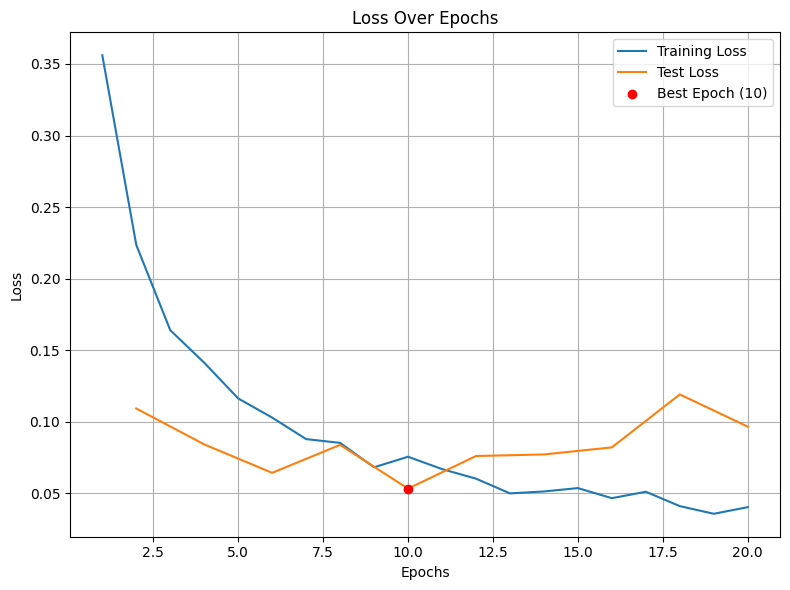

In [71]:
## Using the train-test loss array plot the loss over epochs

epochs_range = np.arange(1, len(train_loss_arr) + 1)

# Get the best epoch and corresponding loss value
best_epoch = early_stopper.best_epoch
best_loss = early_stopper.best_loss

## Get the numpy array to mask nan vals
test_loss_np = np.array(test_loss_arr, dtype=np.float32)
# Get only the valid test loss values (non-NaN)
valid_indices = ~np.isnan(test_loss_np)
valid_test_epochs = epochs_range[valid_indices]
valid_test_loss = test_loss_np[valid_indices]


plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss_arr, label='Training Loss')
plt.plot(valid_test_epochs,valid_test_loss, label='Test Loss')

# Highlight the best epoch
plt.scatter(best_epoch , best_loss, color='red', label=f'Best Epoch ({best_epoch})', zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Get the Accuracy curve

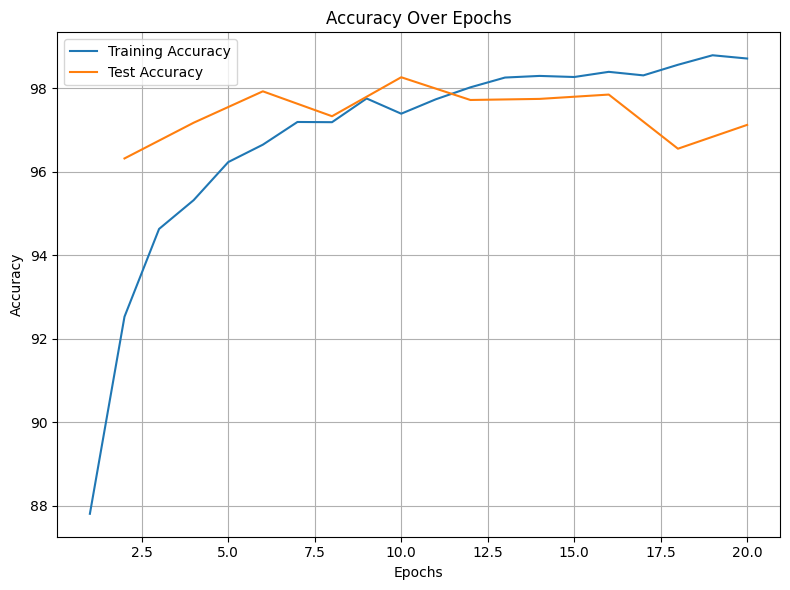

In [72]:
# Plotting
epochs_range = np.arange(1, len(train_acc_arr) + 1)


## Get the numpy array to mask nan vals
test_acc_np = np.array(test_acc_arr, dtype=np.float32)
# Get only the valid test loss values (non-NaN)
valid_indices = ~np.isnan(test_acc_np)
valid_test_epochs = epochs_range[valid_indices]
valid_test_acc = test_acc_np[valid_indices]

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_arr, label='Training Accuracy')
plt.plot(valid_test_epochs, valid_test_acc, label='Test Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
## Model Performance on Train Data

eval_model(model=model,
           data_loader=train_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

{'model_name': 'MobileeNetV2',
 'model_loss': 0.029468635097146034,
 'model_acc': 99.01692708333333}

In [74]:
## Model Performance on Test Data

eval_model(model=model,
           data_loader=test_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

{'model_name': 'MobileeNetV2',
 'model_loss': 0.09669558703899384,
 'model_acc': 97.12136929460581}

## Perform Model Metric Analysis

## Inferencing and Confusion Matrix

In [75]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [76]:
def make_predictions(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    y_preds = []
    y_true = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probabilities and predicted labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            # Collect predictions and true labels
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    # Combine all predictions and true labels into tensors
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


### Importing Deps for Confusion Matrix

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


### Test Data Confusion Matrix

In [78]:
y_preds_test,y_true_test=make_predictions(model=loaded_model,
                 dataloader=test_loader)

Making predictions...: 100%|██████████| 241/241 [00:38<00:00,  6.22it/s]


In [79]:
confmat = ConfusionMatrix(num_classes=len(test_dataset.classes),
                          task="multiclass")

confmat_tensor=confmat(preds=y_preds_test,target=y_true_test)


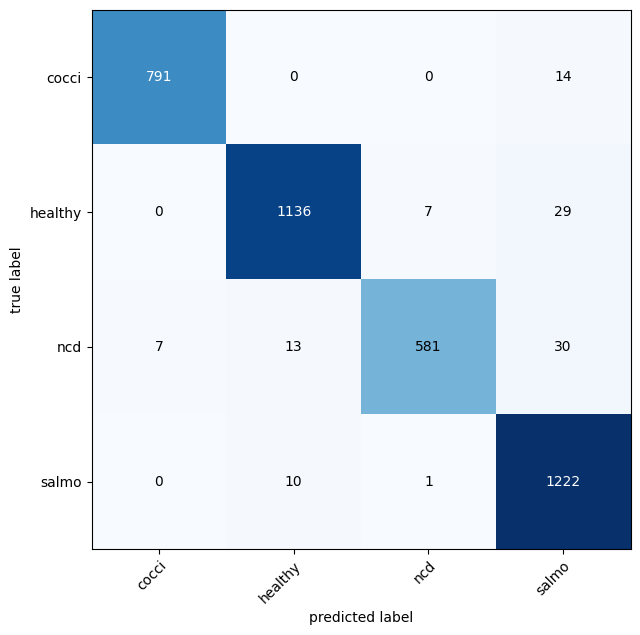

In [80]:
## Plot the confusion matrix

fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(10,7),
                           class_names=train_dataset.classes)
plt.show()

In [81]:
## Metrics

precision = precision_score(y_true_test, y_preds_test, average='weighted')
recall = recall_score(y_true_test, y_preds_test, average='weighted')
f1 = f1_score(y_true_test, y_preds_test, average='weighted')
accuracy=accuracy_score(y_true_test, y_preds_test)


print(f"Precision for Testing Data: {precision:.4f}")
print(f"Recall for Testing Data: {recall:.4f}")
print(f"F1-score for Testing Data: {f1:.4f}")
print(f"Accuracy for Testing Data: {accuracy:.4f}")

Precision for Testing Data: 0.9718
Recall for Testing Data: 0.9711
F1-score for Testing Data: 0.9711
Accuracy for Testing Data: 0.9711


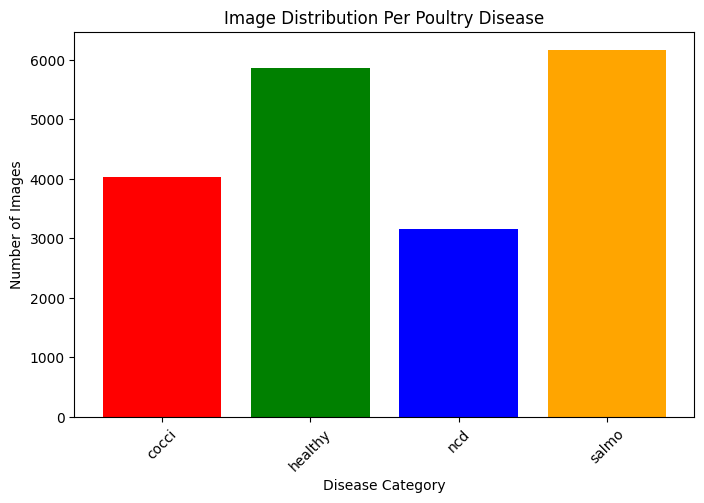

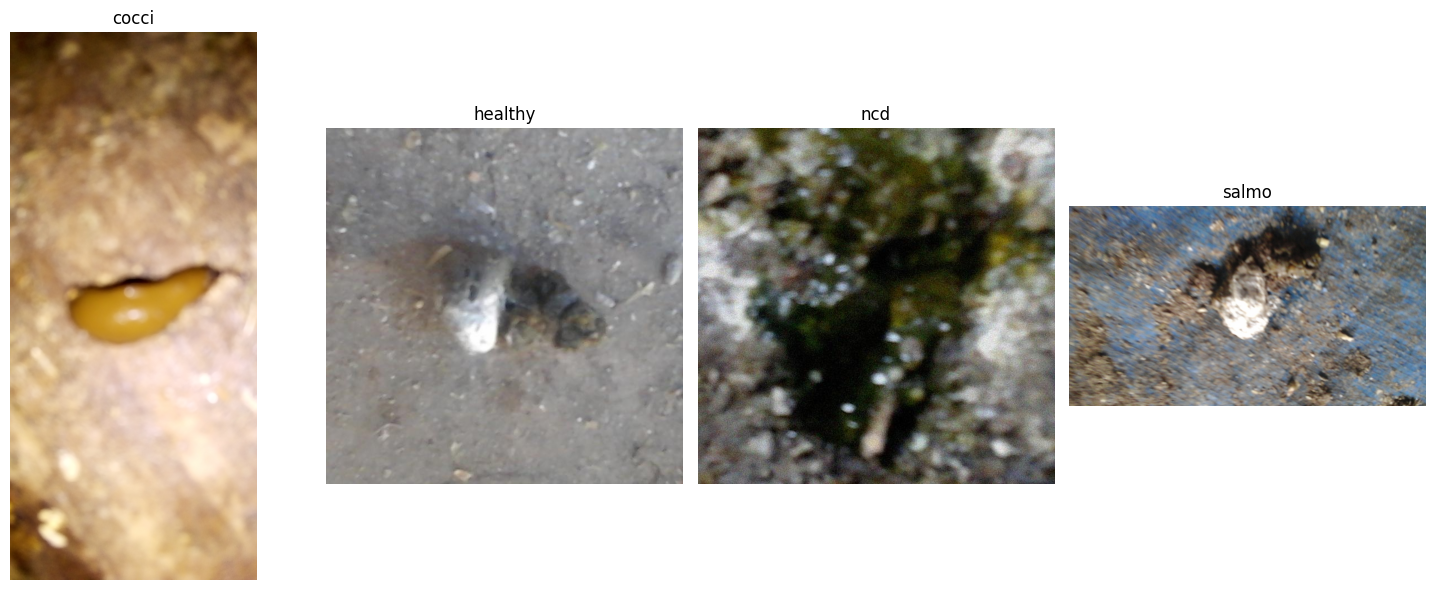

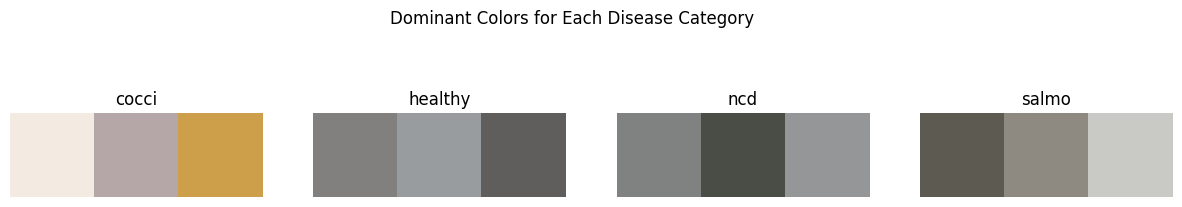

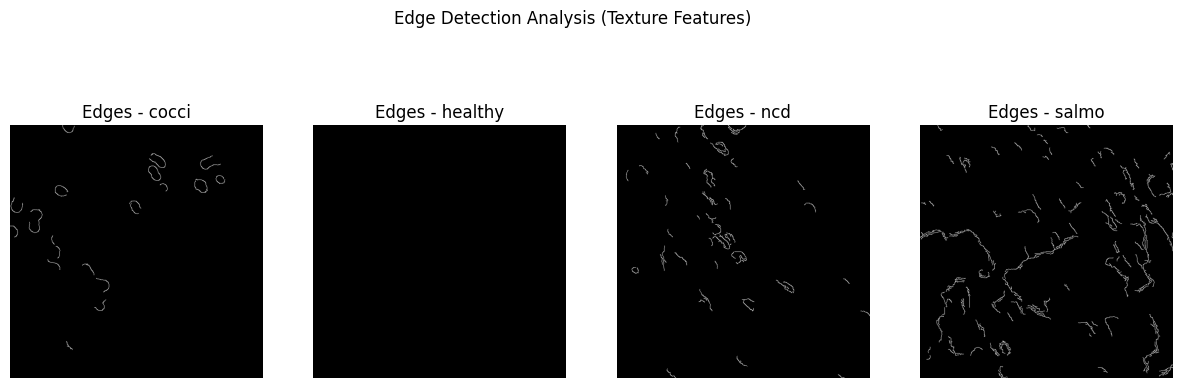

In [3]:
#Data Visualization V1
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

# Set dataset path
dataset_path = "C:\\Users\\aswin\\OneDrive\\Desktop\\Torch Projects\\Chicken-Disease\\dataset"  # Update if necessary
categories = ["cocci", "healthy", "ncd", "salmo"]

# 1. Plot Image Count Per Disease Category
image_counts = {
    cat: len(os.listdir(os.path.join(dataset_path, cat)))
    for cat in categories
}

plt.figure(figsize=(8, 5))
plt.bar(image_counts.keys(), image_counts.values(), color=['red', 'green', 'blue', 'orange'])
plt.xlabel("Disease Category")
plt.ylabel("Number of Images")
plt.title("Image Distribution Per Poultry Disease")
plt.xticks(rotation=45)
plt.show()

# 2. Display Random Sample Images (now using 1 row, not 2)
fig, axes = plt.subplots(1, len(categories), figsize=(15, 6))
for i, category in enumerate(categories):
    img_folder = os.path.join(dataset_path, category)
    img_name = random.choice(os.listdir(img_folder))
    img_path = os.path.join(img_folder, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# 3. Color Analysis - Dominant Colors per Category
def get_dominant_color(image, k=3):
    img = cv2.resize(image, (100, 100))  # Resize for faster processing
    img = img.reshape((-1, 3))          # Convert to 2D array (pixels × RGB)

    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img)
    dominant_color = kmeans.cluster_centers_.astype(int)

    return dominant_color

fig, axes = plt.subplots(1, len(categories), figsize=(15, 3))
for i, category in enumerate(categories):
    img_folder = os.path.join(dataset_path, category)
    img_name = random.choice(os.listdir(img_folder))
    img_path = os.path.join(img_folder, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dominant_colors = get_dominant_color(img)

    # Display the dominant colors as a row of patches
    axes[i].imshow([dominant_colors / 255])  # Normalize colors for display
    axes[i].set_title(category)
    axes[i].axis("off")

plt.suptitle("Dominant Colors for Each Disease Category")
plt.show()

# 4. Texture Analysis using Edge Detection
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
for i, category in enumerate(categories):
    img_folder = os.path.join(dataset_path, category)
    img_name = random.choice(os.listdir(img_folder))
    img_path = os.path.join(img_folder, img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    edges = cv2.Canny(img, 50, 150)                   # Edge detection

    axes[i].imshow(edges, cmap='gray')
    axes[i].set_title(f"Edges - {category}")
    axes[i].axis("off")

plt.suptitle("Edge Detection Analysis (Texture Features)")
plt.show()

In [25]:
#-- Data Visualisation V2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from tqdm import tqdm  # Import tqdm for progress bar

# --- Feature Extraction Functions (same as before) ---
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image, numPoints=24, radius=8):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    lbp = local_binary_pattern(gray, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_glcm_features(image, distances=[5], angles=[0]):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    gray = (gray / 32).astype(np.uint8)  # Quantize to 8 gray levels (0–7)

    glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]

    return np.array([contrast, dissimilarity, homogeneity, energy, correlation, ASM])

# --- Load All Images and Extract Features ---

dataset_path = "C:\\Users\\aswin\\OneDrive\\Desktop\\Torch Projects\\Chicken-Disease\\dataset"
categories = ["cocci", "healthy", "ncd", "salmo"]

data = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Limit the number of images to 500 per category
    image_files = image_files[:500]  # Take only the first 500 images from the folder

    # Wrap the image files list with tqdm to display progress bar
    for image_file in tqdm(image_files, desc=f"Processing {category} images", unit="image"):
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)
        if img is None:
            continue  # skip if the image can't be read
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract all features
        color_hist = extract_color_histogram(img)
        lbp_feat = extract_lbp_features(img)
        glcm_feat = extract_glcm_features(img)

        features = np.concatenate([color_hist, lbp_feat, glcm_feat])
        data.append((features, category))

print(f"Total images processed: {len(data)}")


Processing salmo images: 100%|██████████| 500/500 [00:57<00:00,  8.70image/s]

Total images processed: 2000


Feature Mean: [1.17323684e-02 1.64152129e-02 3.80518987e-02 1.16337477e-01
 2.48048784e-01 9.03587931e-02 4.85742178e-02 9.32723132e-02
 4.10943666e-03 1.94167300e-02 4.10433484e-02 8.28984468e-02
 1.12130923e-01 7.65601554e-02 5.89645369e-02 5.52667496e-02
 4.35651776e-03 1.67189534e-02 3.44143268e-02 5.01529647e-02
 5.53580069e-02 4.82998063e-02 3.85015811e-02 3.19178832e-02
 3.52535744e-03 1.36992248e-02 2.41461574e-02 2.99201693e-02
 3.32212071e-02 3.17153561e-02 2.66172456e-02 3.08757433e-02
 3.15378918e-03 9.91089524e-03 1.65538499e-02 1.95282325e-02
 2.37811104e-02 2.26424398e-02 2.96299312e-02 3.33980094e-02
 2.82187031e-03 7.39138029e-03 1.08489056e-02 1.17210218e-02
 1.28302133e-02 1.77272668e-02 2.06679281e-02 1.20529665e-02
 2.38350357e-03 6.39742958e-03 6.08261164e-03 6.61911292e-03
 6.76352453e-03 5.98286248e-03 5.55059802e-03 3.14344048e-03
 4.88218466e-03 6.67752104e-03 4.35587317e-03 3.84437753e-03
 1.53795502e-03 5.04160696e-04 2.66920794e-04 8.63571929e-05
 1.8909292

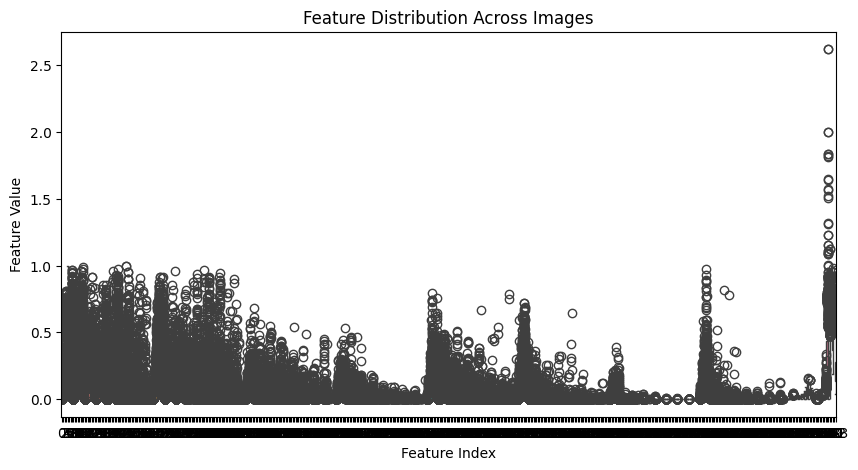

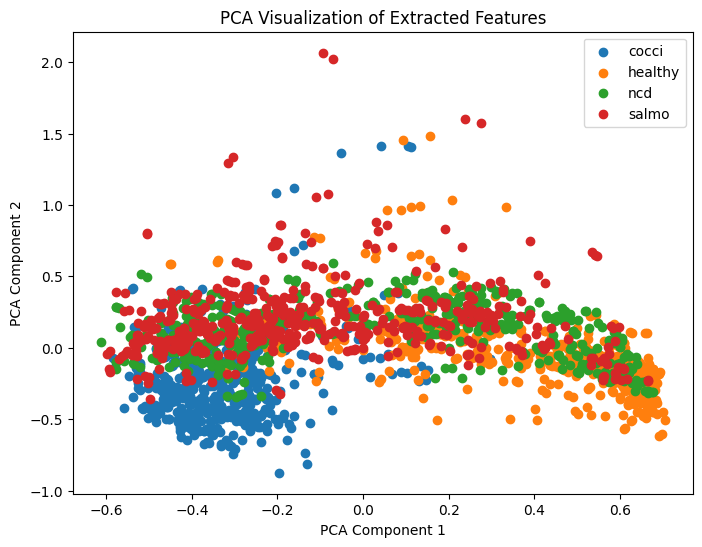

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Convert feature list to NumPy array for analysis
feature_vectors = np.array([item[0] for item in data])  # item[0] contains features
categories = np.array([item[1] for item in data])  # item[1] contains categories

# Compute summary statistics
means = np.mean(feature_vectors, axis=0)
stds = np.std(feature_vectors, axis=0)

print("Feature Mean:", means)
print("Feature Standard Deviation:", stds)

# Visualizing feature distributions
plt.figure(figsize=(10, 5))
sns.boxplot(data=feature_vectors)
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Feature Distribution Across Images")
plt.show()

# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_vectors)

plt.figure(figsize=(8, 6))
for cat in np.unique(categories):
    plt.scatter(reduced_features[categories == cat, 0], reduced_features[categories == cat, 1], label=cat)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Extracted Features")
plt.legend()
plt.show()


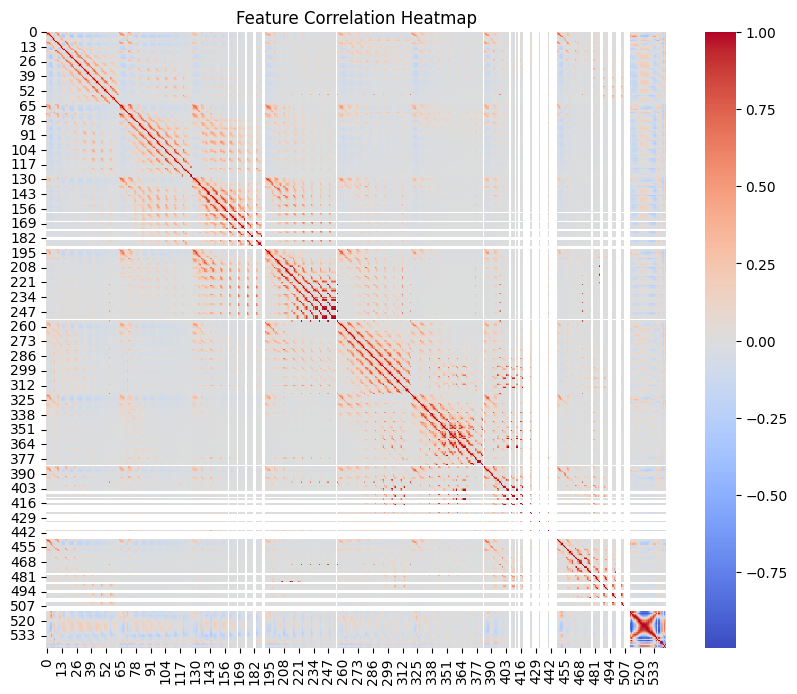

In [27]:
#Feature Co-relation Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert feature vectors into a DataFrame
df = pd.DataFrame(feature_vectors)

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


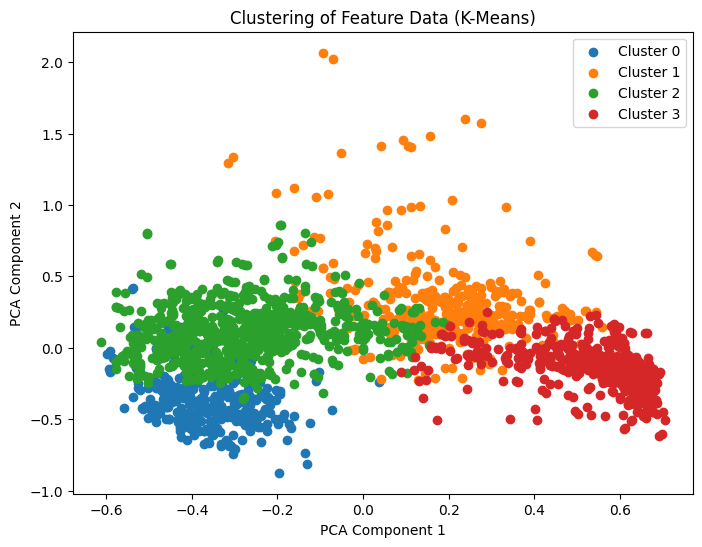

In [28]:
#Clustering to Identify Patterns
from sklearn.cluster import KMeans

num_clusters = len(np.unique(categories))  # Assuming the number of clusters is equal to disease categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(feature_vectors)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], label=f"Cluster {i}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Feature Data (K-Means)")
plt.legend()
plt.show()

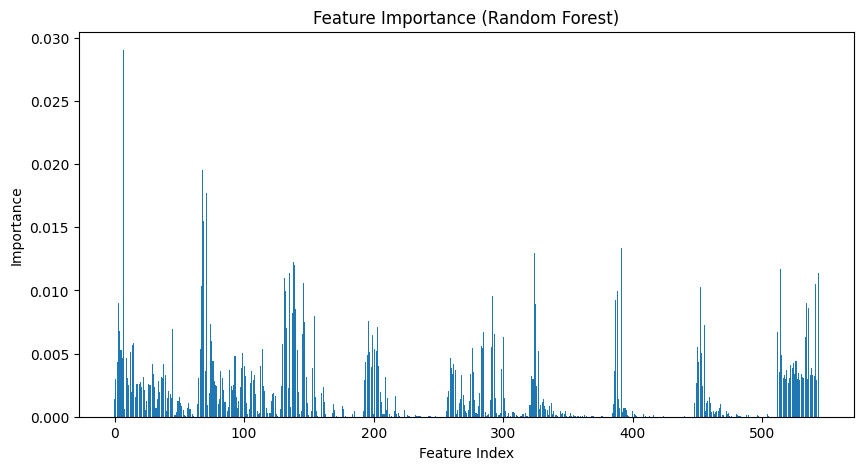

In [29]:
#Feature Importance Using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Convert category labels into numerical values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(categories)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

Running PCA...
PCA finished.
Running t-SNE (2D)...


c:\Users\aswin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE (2D) finished.
Running t-SNE (3D)...


c:\Users\aswin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE (3D) finished.
Plotting PCA 2D...


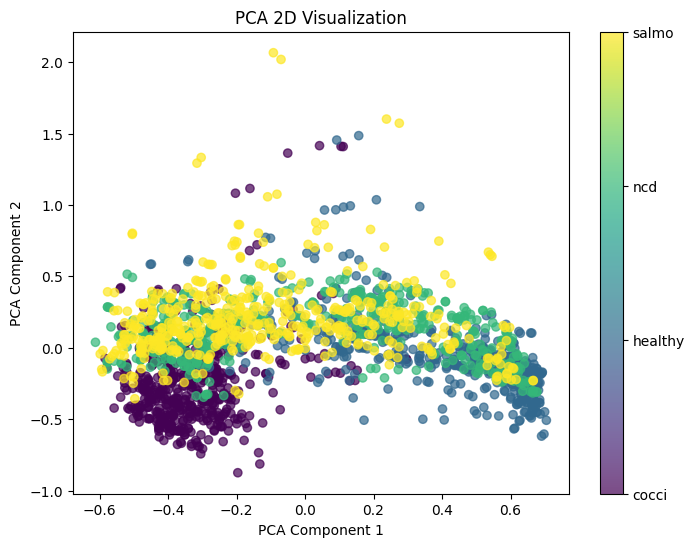

Plotting PCA 3D...


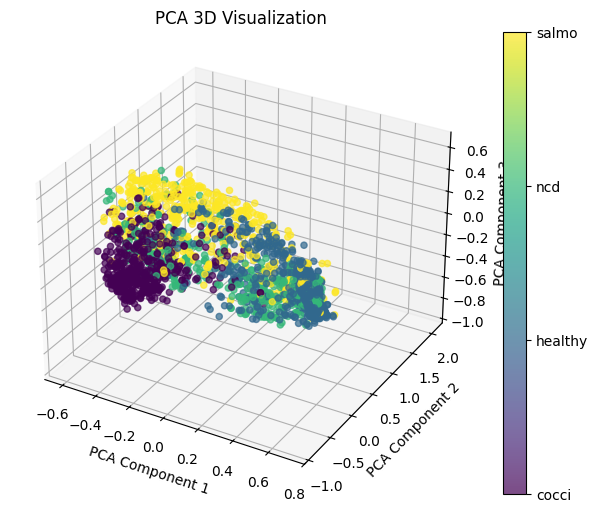

Plotting t-SNE 2D...


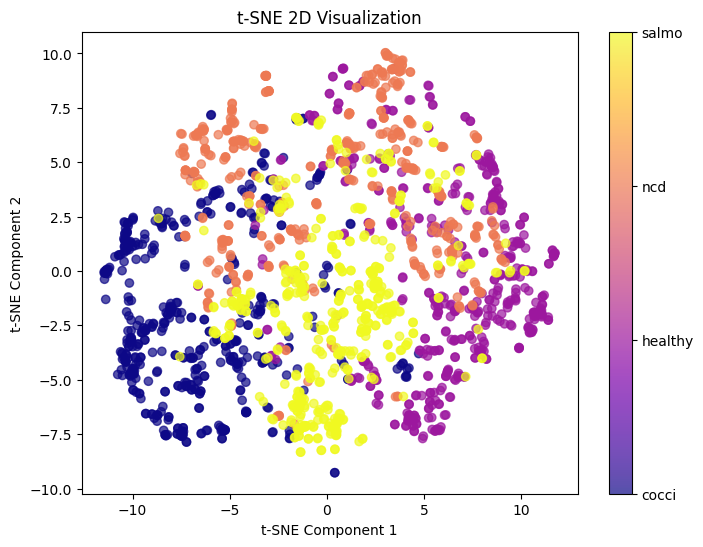

Plotting t-SNE 3D...


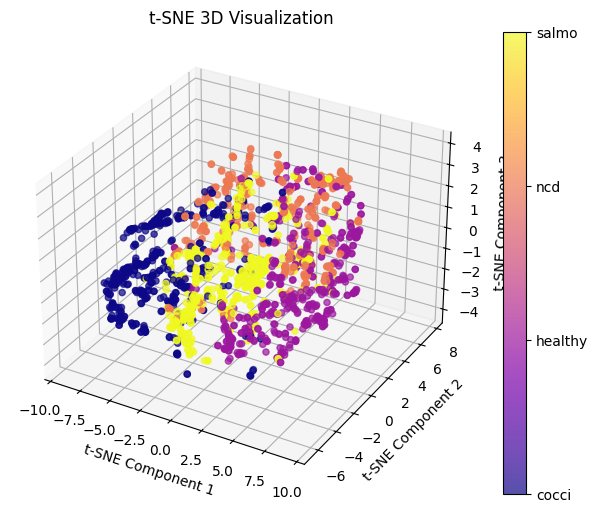

All plots generated.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Explicit import for 3D projection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assume 'data' is loaded and contains [(feature_vector, label), ...]
# Example dummy data if you don't have 'data' loaded:
# data = [(np.random.rand(10), label) for label in ['cocci']*50 + ['healthy']*50 + ['ncd']*50 + ['salmo']*50]
# np.random.shuffle(data)


# Extract features and labels
feature_vectors = np.array([item[0] for item in data])  # item[0] contains features
labels = np.array([item[1] for item in data])  # item[1] contains categories

# Convert labels to numerical values AND get the names in order
# Use sorted to ensure the order matches the numeric indices 0, 1, 2...
unique_labels = sorted(list(set(labels)))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
numerical_labels = np.array([label_to_index[label] for label in labels])

# --- PCA for Dimensionality Reduction ---
print("Running PCA...")
pca_2d = PCA(n_components=2)
features_pca_2d = pca_2d.fit_transform(feature_vectors)

pca_3d = PCA(n_components=3)
features_pca_3d = pca_3d.fit_transform(feature_vectors)
print("PCA finished.")

# --- t-SNE for Non-linear Dimensionality Reduction ---
# Note: t-SNE can be slow on large datasets
print("Running t-SNE (2D)...")
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=300) # Reduced iterations for speed if needed
features_tsne_2d = tsne_2d.fit_transform(feature_vectors)
print("t-SNE (2D) finished.")

print("Running t-SNE (3D)...")
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=300) # Reduced iterations for speed if needed
features_tsne_3d = tsne_3d.fit_transform(feature_vectors)
print("t-SNE (3D) finished.")


# --- Plotting ---

# Define number of categories and get category names in order
num_categories = len(unique_labels)
category_names = unique_labels # Already sorted

# --- Plot PCA 2D ---
print("Plotting PCA 2D...")
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA 2D Visualization')
# Create colorbar and set ticks and labels
cbar = plt.colorbar(scatter, ticks=np.arange(num_categories))
cbar.set_ticklabels(category_names)
plt.show()

# --- Plot PCA 3D ---
print("Plotting PCA 3D...")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca_3d[:, 0], features_pca_3d[:, 1], features_pca_3d[:, 2], c=numerical_labels, cmap='viridis', alpha=0.7)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('PCA 3D Visualization')
# Create colorbar and set ticks and labels
cbar = fig.colorbar(scatter, ax=ax, ticks=np.arange(num_categories))
cbar.set_ticklabels(category_names)
plt.show()

# --- Plot t-SNE 2D ---
print("Plotting t-SNE 2D...")
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1], c=numerical_labels, cmap='plasma', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE 2D Visualization')
# Create colorbar and set ticks and labels
cbar = plt.colorbar(scatter, ticks=np.arange(num_categories))
cbar.set_ticklabels(category_names)
plt.show()

# --- Plot t-SNE 3D ---
print("Plotting t-SNE 3D...")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne_3d[:, 0], features_tsne_3d[:, 1], features_tsne_3d[:, 2], c=numerical_labels, cmap='plasma', alpha=0.7)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE 3D Visualization')
# Create colorbar and set ticks and labels
cbar = fig.colorbar(scatter, ax=ax, ticks=np.arange(num_categories))
cbar.set_ticklabels(category_names)
plt.show()

print("All plots generated.")

## Saving the Model

In [63]:
import os

In [64]:
os.makedirs(os.path.join(os.getcwd(),"models"),exist_ok=True)
MODEL_NAME="chicken_es_mobilenet_CNN_moredata.pt"
MODEL_PATH=os.path.join(os.getcwd(),"models",MODEL_NAME)

In [65]:
print(f"Saving model to: {MODEL_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_PATH)

Saving model to: c:\Users\aswin\OneDrive\Desktop\Torch Projects\Chicken-Disease\Notebooks\models\chicken_es_mobilenet_CNN_moredata.pt


## Loading the Model

In [68]:
loaded_model=MobileeNetV2(num_classes=4).to(device)

In [69]:
loaded_model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>